In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
from tqdm import tqdm
import csv
import time 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from torchvision import transforms

#import geoopt
import cv2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
class Config:

    train_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr'
    labels_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr'


    vol_paths = list()
    seg_paths = list()

    n_classes = 1
    vols_count = None
    segs_count = None

    window = (-30,140)

    epochs = 30
    batch_size = 24
    learning_rate = 1e-4

In [4]:
for file in os.listdir(Config.train_dir):
    if file.endswith('.nii'):

        Config.vol_paths.append(os.path.join(Config.train_dir,file))
        Config.seg_paths.append(os.path.join(Config.labels_dir,file))

Config.vols_count = len(Config.vol_paths)
Config.segs_count = len(Config.seg_paths)

print('Total CT Scan Volumes for Train:', Config.vols_count)
print('Total Segmentation masks:', Config.segs_count)

Total CT Scan Volumes for Train: 123
Total Segmentation masks: 123


In [5]:
path = Config.vol_paths[1]
data = nib.load(path).get_fdata().transpose(2,1,0)
seg = nib.load(Config.seg_paths[1]).get_fdata().transpose(2,1,0)

In [6]:
seg.shape

(183, 210, 210)

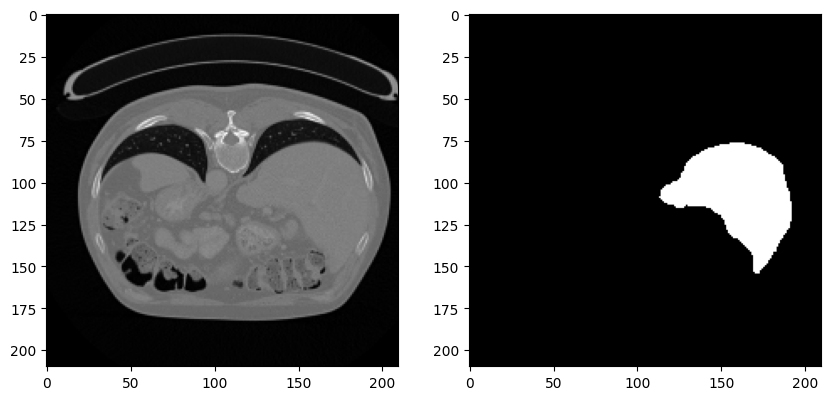

In [7]:
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(seg[150], cmap = 'gray')
plt.show()

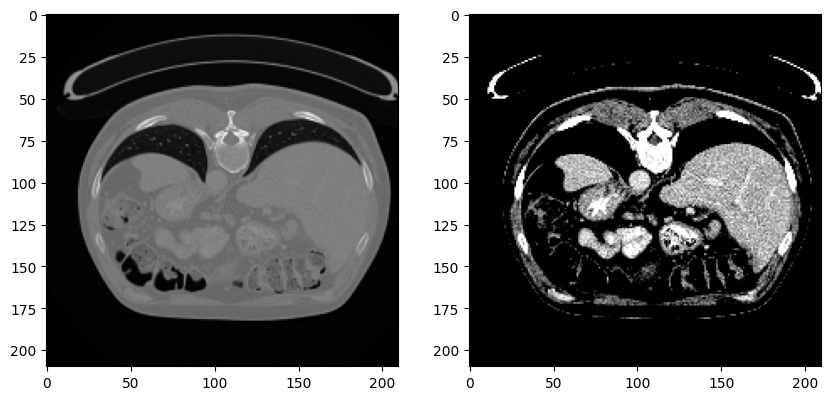

In [8]:
win_img = np.clip(data[150], -30,140)
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(win_img, cmap = 'gray')
plt.show()

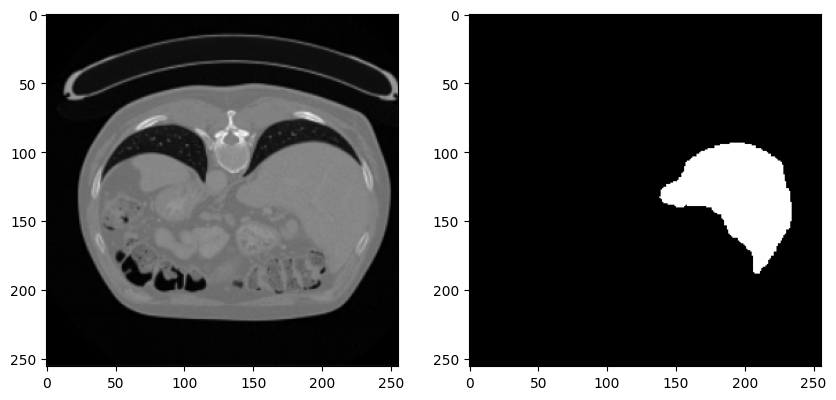

In [9]:
resized_X = resize(data[150], (256, 256), mode='constant', preserve_range=True, anti_aliasing=True)
resized_Y = resize(seg[150], (256, 256), mode='constant', preserve_range=True, order=0)

_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(resized_X, cmap = 'gray')
axes[1].imshow(resized_Y, cmap = 'gray')
plt.show()

In [10]:
# dataset = []

# for idx,seg_path in tqdm(enumerate(Config.seg_paths)):
#     seg = nib.load(seg_path).get_fdata().transpose(2, 1, 0)
    
#     for slice_idx, mask in enumerate(seg):
#         liver_mask = mask.sum() > 0 
#         dataset.append((slice_idx, liver_mask, Config.vol_paths[idx], Config.seg_paths[idx]))

In [11]:
dataset = None

if dataset is not None:
    dataset = pd.DataFrame(dataset, columns = ['slice_idx', 'liver_mask_exists', 'vol_path', 'seg_path'])
    dataset.to_csv('liver-path-data.csv', index= False)
else:
    dataset = pd.read_csv('/kaggle/input/liver-path-data/liver-path-data.csv')

dataset.head()

,slice_idx,liver_mask_exists,vol_path,seg_path
0,0,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
1,1,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
2,2,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
3,3,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
4,4,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...


In [12]:
print("Total CT slices: ", len(dataset))
print("Slices with Liver: ", sum(dataset.liver_mask_exists))
print("Slices without Liver: ", len(dataset) - sum(dataset.liver_mask_exists))

Total CT slices:  19604
Slices with Liver:  6413
Slices without Liver:  13191


In [13]:
# OverSampling Liver mask slices
liver_mask_slices = dataset[dataset.liver_mask_exists]

dataset = pd.concat([dataset, liver_mask_slices], ignore_index=True)

dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

print("Total CT slices: ", len(dataset))
print("Slices with Liver: ", sum(dataset.liver_mask_exists))
print("Slices without Liver: ",len(dataset) - sum(dataset.liver_mask_exists))

Total CT slices:  26017
Slices with Liver:  12826
Slices without Liver:  13191


In [14]:
class LiverDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self.slice_data = data
        self.augmentation = transforms.Compose([
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomHorizontalFlip(p=0.5),
        ])

    def __len__(self):
        return len(self.slice_data)

    def __getitem__(self, idx):
        slice_idx, liver_mask_exists, vol_path, seg_path = self.slice_data.iloc[idx]

        # Load volume and segmentation mask
        vol = nib.load(vol_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        # Extract the corresponding slice
        X = vol[:, :, slice_idx].transpose(1,0)
        Y = seg[:, :, slice_idx].transpose(1,0) > 0

        # Resize images and masks
        X = resize(X, (256, 256), mode='constant', preserve_range=True, anti_aliasing=True)
        Y = resize(Y, (256, 256), mode='constant', preserve_range=True, order=0)  # Nearest-neighbor for masks

        # Apply preprocessing (windowing & normalization)
        X = self.preprocess(X)

        # Convert to torch tensors
        X = torch.from_numpy(X).float().unsqueeze(0)
        Y = torch.from_numpy(Y).float().unsqueeze(0)

        # Apply augmentations if liver mask exists
        if liver_mask_exists:
            X, Y = self.apply_augmentations(X, Y)

        return X, Y

    def preprocess(self, ct_scan: np.ndarray, window: tuple = Config.window) -> np.ndarray:
        """Applying windowing and normalizing"""
        min_value, max_value = window

        # Apply windowing
        windowed_ct = np.clip(ct_scan, min_value, max_value)

        # Normalize to 0-1
        return (windowed_ct - min_value) / (max_value - min_value)

    def apply_augmentations(self, X, Y):
        """Apply augmentations to image and mask together"""
        stacked = torch.cat([X, Y], dim=0)
        stacked = self.augmentation(stacked)
        
        return stacked[0:1, :, :], stacked[1:2, :, :]

In [15]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42, stratify = dataset.liver_mask_exists)

In [16]:
train_dataset = LiverDataset(train)
train_dataloader = DataLoader(train_dataset, batch_size = Config.batch_size, shuffle = True)

val_dataset = LiverDataset(test)
val_dataloader = DataLoader(val_dataset, batch_size = Config.batch_size, shuffle = False)

In [17]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)


        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) 

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        self.final_activation = nn.Sigmoid()

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        # Encoder
        x = F.relu(self.e11(x))
        x1 = F.relu(self.e12(x))
        x = self.pool1(x1)

        x = F.relu(self.e21(x))
        x2 = F.relu(self.e22(x))
        x = self.pool2(x2)

        x = F.relu(self.e31(x))
        x3 = F.relu(self.e32(x))
        x = self.pool3(x3)

        x = F.relu(self.e41(x))
        x4 = F.relu(self.e42(x))
        x = self.pool4(x4)

        x = F.relu(self.e51(x))
        x = F.relu(self.e52(x))

        # Decoder
        x = self.upconv1(x)
        x = torch.cat([x,x4],dim=1)
        x = F.relu(self.d11(x))
        x = F.relu(self.d12(x))

        x = self.upconv2(x)
        x = torch.cat([x,x3],dim=1)
        x = F.relu(self.d21(x))
        x = F.relu(self.d22(x))

        x = self.upconv3(x)
        x = torch.cat([x,x2],dim=1)
        x = F.relu(self.d31(x))
        x = F.relu(self.d32(x))

        x = self.upconv4(x)
        x = torch.cat([x,x1],dim=1)
        x = F.relu(self.d41(x))
        x = F.relu(self.d42(x))

        out = self.outconv(x)

        return self.final_activation(out) # B, 1, 256, 256

In [18]:
def dice_coefficient(preds, masks, smooth=1e-6):
    intersection = torch.sum(preds * masks, dim=(1,2,3))
    union = torch.sum(preds, dim=(1,2,3)) + torch.sum(masks, dim=(1,2,3))

    dice_score = (2. * intersection) / (union + smooth)

    valid_masks = union > 0
    if valid_masks.sum() == 0:  
        return torch.tensor(0.0, device=preds.device)

    return dice_score[valid_masks].mean() 

def dice_loss(preds, masks):
    return 1 - dice_coefficient(preds, masks)

def precision(preds, targets):

    targets = targets.float()

    tp = (preds * targets).sum()
    fp = (preds * (1 - targets)).sum()

    precision = tp / (tp + fp + 1e-8)
    return precision.item()

def recall(preds, targets):

    targets = targets.float()

    tp = (preds * targets).sum()
    fn = ((1 - preds) * targets).sum()

    recall = tp/ (tp + fn + 1e-8)
    return recall.item()

def mIou(pred, target):
    
    target = target.float()

    intersection = (pred * target).sum(dim=(1,2,3))
    union = (pred + target).sum(dim=(1,2,3)) - intersection 

    iou = (intersection) / (union + 1e-8)
    valid_masks = union > 0
    if valid_masks.sum() == 0:  
        return torch.tensor(0.0, device=preds.device)

    return iou[valid_masks].mean().item()

In [19]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_class=1).to(device)
model.apply(model.init_weights)

optimizer = torch.optim.Adam(model.parameters(), lr = Config.learning_rate)

summary(model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
            Conv2d-2         [-1, 64, 256, 256]          36,928
         MaxPool2d-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
            Conv2d-5        [-1, 128, 128, 128]         147,584
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
            Conv2d-8          [-1, 256, 64, 64]         590,080
         MaxPool2d-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 512, 32, 32]       1,180,160
           Conv2d-11          [-1, 512, 32, 32]       2,359,808
        MaxPool2d-12          [-1, 512, 16, 16]               0
           Conv2d-13         [-1, 1024, 16, 16]       4,719,616
           Conv2d-14         [-1, 1024,

In [20]:
# Training parameters
num_epochs = Config.epochs
best_dice_coefficient = 0
total_training_time = 0

log_file = "unet-dice-aug-lr_4-50e.csv"  
log_fields = ["epoch", "time", "train_loss", "val_loss", "dice_train", "dice_val", 
              "mIou_train", "mIou_val", "precision_train", "precision_val", "recall_train", "recall_val"]

# Initialize logging file
with open(log_file, 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=log_fields)
    writer.writeheader()

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()

    train_loss, train_dice, train_miou, train_precision, train_recall = 0, 0, 0, 0, 0

    train_iterator = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Epoch {epoch+1}")

    for i, (inputs, masks) in train_iterator:
        inputs, masks = inputs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # Ensure sigmoid activation

        loss = dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        # Convert outputs to binary for metric calculations
        outputs_bin = (outputs >= 0.5).float()

        # Calculate metrics
        dice = dice_coefficient(outputs_bin, masks)
        precision_score = precision(outputs_bin, masks)
        recall_score = recall(outputs_bin, masks)
        miou_score = mIou(outputs_bin, masks)

        # Accumulate metrics
        train_loss += loss.item()
        train_dice += dice.item()
        train_miou += miou_score
        train_recall += recall_score
        train_precision += precision_score

        train_iterator.set_postfix({
            'loss': f"{train_loss/(i+1) :.4f}",
            'dice': f"{train_dice/(i+1) :.4f}",
            'miou': f"{train_miou/(i+1) :.4f}",
            'precision': f"{train_precision/(i+1) :.4f}",
            'recall': f"{train_recall/(i+1) :.4f}"
        })

    # Compute average training metrics
    train_loss /= len(train_dataloader)
    train_dice /= len(train_dataloader)
    train_miou /= len(train_dataloader)
    train_recall /= len(train_dataloader)
    train_precision /= len(train_dataloader)

    model.eval()
    val_loss, val_dice, val_miou, val_precision, val_recall = 0, 0, 0, 0, 0

    with torch.no_grad():  # No gradient calculation in validation
        for inputs, masks in val_dataloader:
            inputs, masks = inputs.to(device), masks.to(device)
            outputs = model(inputs)

            loss = dice_loss(outputs, masks)
            outputs_bin = (outputs > 0.5).float()

            dice = dice_coefficient(outputs_bin, masks)
            precision_score = precision(outputs_bin, masks)
            recall_score = recall(outputs_bin, masks)
            miou_score = mIou(outputs_bin, masks)

            val_loss += loss.item()
            val_dice += dice.item()
            val_miou += miou_score
            val_recall += recall_score
            val_precision += precision_score

    # Compute average validation metrics
    val_loss /= len(val_dataloader)
    val_dice /= len(val_dataloader)
    val_miou /= len(val_dataloader)
    val_recall /= len(val_dataloader)
    val_precision /= len(val_dataloader)

    epoch_time = time.time() - start_time
    total_training_time += epoch_time

    print(f"\nEpoch {epoch+1}/{num_epochs}: Time {epoch_time:.2f}s | Train Dice: {train_dice:.4f} | Val Dice: {val_dice:.4f}")

    # Save best model based on Dice score
    if val_dice > best_dice_coefficient:
        best_dice_coefficient = val_dice
        torch.save(model.state_dict(), "unet-dice-aug-lr_4-50e.pth")
        print(f"Model saved at epoch {epoch+1} with Dice: {val_dice:.4f}")

    # Log training and validation metrics
    with open(log_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=log_fields)
        writer.writerow({
            "epoch": epoch + 1,
            "time": round(epoch_time, 2),
            "train_loss": round(train_loss, 4),
            "val_loss": round(val_loss, 4),
            "dice_train": round(train_dice, 4),
            "dice_val": round(val_dice, 4),
            "mIou_train": round(train_miou, 4),
            "mIou_val": round(val_miou, 4),
            "precision_train": round(train_precision, 4),
            "precision_val": round(val_precision, 4),
            "recall_train": round(train_recall, 4),
            "recall_val": round(val_recall, 4),
        })

print(f"Training Complete in {total_training_time:.4f}s with {total_training_time/num_epochs:.4f}s per epoch.")

Epoch 1: 100%|██████████| 868/868 [22:26<00:00,  1.55s/it, loss=0.6487, dice=0.3773, miou=0.3242, precision=0.5516, recall=0.8809]



Epoch 1/30: Time 1551.76s | Train Dice: 0.3773 | Val Dice: 0.3908
Model saved at epoch 1 with Dice: 0.3908


Epoch 2: 100%|██████████| 868/868 [19:43<00:00,  1.36s/it, loss=0.6018, dice=0.4483, miou=0.4013, precision=0.6709, recall=0.9073]



Epoch 2/30: Time 1394.43s | Train Dice: 0.4483 | Val Dice: 0.4873
Model saved at epoch 2 with Dice: 0.4873


Epoch 3: 100%|██████████| 868/868 [18:34<00:00,  1.28s/it, loss=0.5898, dice=0.4648, miou=0.4220, precision=0.7170, recall=0.9177]



Epoch 3/30: Time 1324.55s | Train Dice: 0.4648 | Val Dice: 0.4106


Epoch 4: 100%|██████████| 868/868 [20:22<00:00,  1.41s/it, loss=0.5830, dice=0.4773, miou=0.4365, precision=0.7472, recall=0.9270]



Epoch 4/30: Time 1423.59s | Train Dice: 0.4773 | Val Dice: 0.4825


Epoch 5: 100%|██████████| 868/868 [19:04<00:00,  1.32s/it, loss=0.5765, dice=0.4946, miou=0.4553, precision=0.7694, recall=0.9343]



Epoch 5/30: Time 1359.24s | Train Dice: 0.4946 | Val Dice: 0.6270
Model saved at epoch 5 with Dice: 0.6270


Epoch 6: 100%|██████████| 868/868 [19:40<00:00,  1.36s/it, loss=0.5710, dice=0.5157, miou=0.4778, precision=0.8078, recall=0.9370]



Epoch 6/30: Time 1383.78s | Train Dice: 0.5157 | Val Dice: 0.5393


Epoch 7: 100%|██████████| 868/868 [18:38<00:00,  1.29s/it, loss=0.5652, dice=0.5196, miou=0.4843, precision=0.8262, recall=0.9438]



Epoch 7/30: Time 1318.43s | Train Dice: 0.5196 | Val Dice: 0.5696


Epoch 8: 100%|██████████| 868/868 [18:42<00:00,  1.29s/it, loss=0.5652, dice=0.5209, miou=0.4853, precision=0.8273, recall=0.9455]



Epoch 8/30: Time 1332.16s | Train Dice: 0.5209 | Val Dice: 0.6312
Model saved at epoch 8 with Dice: 0.6312


Epoch 9: 100%|██████████| 868/868 [20:08<00:00,  1.39s/it, loss=0.5634, dice=0.5271, miou=0.4919, precision=0.8308, recall=0.9452]



Epoch 9/30: Time 1410.97s | Train Dice: 0.5271 | Val Dice: 0.4751


Epoch 10: 100%|██████████| 868/868 [19:12<00:00,  1.33s/it, loss=0.5577, dice=0.5413, miou=0.5074, precision=0.8413, recall=0.9499]



Epoch 10/30: Time 1343.17s | Train Dice: 0.5413 | Val Dice: 0.5727


Epoch 11: 100%|██████████| 868/868 [18:52<00:00,  1.30s/it, loss=0.5560, dice=0.5493, miou=0.5160, precision=0.8620, recall=0.9506]



Epoch 11/30: Time 1331.63s | Train Dice: 0.5493 | Val Dice: 0.4789


Epoch 12: 100%|██████████| 868/868 [18:51<00:00,  1.30s/it, loss=0.5574, dice=0.5532, miou=0.5191, precision=0.8606, recall=0.9495]



Epoch 12/30: Time 1333.37s | Train Dice: 0.5532 | Val Dice: 0.5925


Epoch 13: 100%|██████████| 868/868 [20:47<00:00,  1.44s/it, loss=0.5551, dice=0.5329, miou=0.5007, precision=0.8602, recall=0.9532]



Epoch 13/30: Time 1447.75s | Train Dice: 0.5329 | Val Dice: 0.4742


Epoch 14: 100%|██████████| 868/868 [18:47<00:00,  1.30s/it, loss=0.5518, dice=0.5575, miou=0.5251, precision=0.8620, recall=0.9539]



Epoch 14/30: Time 1327.27s | Train Dice: 0.5575 | Val Dice: 0.6615
Model saved at epoch 14 with Dice: 0.6615


Epoch 15: 100%|██████████| 868/868 [20:18<00:00,  1.40s/it, loss=0.5515, dice=0.5418, miou=0.5101, precision=0.8645, recall=0.9533]



Epoch 15/30: Time 1435.96s | Train Dice: 0.5418 | Val Dice: 0.4853


Epoch 16: 100%|██████████| 868/868 [20:04<00:00,  1.39s/it, loss=0.5496, dice=0.5604, miou=0.5289, precision=0.8635, recall=0.9554]



Epoch 16/30: Time 1420.26s | Train Dice: 0.5604 | Val Dice: 0.6102


Epoch 17: 100%|██████████| 868/868 [19:00<00:00,  1.31s/it, loss=0.5500, dice=0.5600, miou=0.5282, precision=0.8662, recall=0.9543]



Epoch 17/30: Time 1331.34s | Train Dice: 0.5600 | Val Dice: 0.6458


Epoch 18: 100%|██████████| 868/868 [19:41<00:00,  1.36s/it, loss=0.5495, dice=0.5714, miou=0.5387, precision=0.8749, recall=0.9539]



Epoch 18/30: Time 1372.74s | Train Dice: 0.5714 | Val Dice: 0.4644


Epoch 19: 100%|██████████| 868/868 [18:37<00:00,  1.29s/it, loss=0.5465, dice=0.5532, miou=0.5233, precision=0.8801, recall=0.9574]



Epoch 19/30: Time 1326.31s | Train Dice: 0.5532 | Val Dice: 0.6384


Epoch 20: 100%|██████████| 868/868 [19:37<00:00,  1.36s/it, loss=0.5432, dice=0.5881, miou=0.5580, precision=0.8857, recall=0.9593]



Epoch 20/30: Time 1376.64s | Train Dice: 0.5881 | Val Dice: 0.5297


Epoch 21: 100%|██████████| 868/868 [19:02<00:00,  1.32s/it, loss=0.5471, dice=0.5708, miou=0.5403, precision=0.8732, recall=0.9552]



Epoch 21/30: Time 1335.61s | Train Dice: 0.5708 | Val Dice: 0.6077


Epoch 22: 100%|██████████| 868/868 [18:54<00:00,  1.31s/it, loss=0.5459, dice=0.5874, miou=0.5563, precision=0.8791, recall=0.9575]



Epoch 22/30: Time 1334.81s | Train Dice: 0.5874 | Val Dice: 0.6432


Epoch 23: 100%|██████████| 868/868 [18:36<00:00,  1.29s/it, loss=0.5439, dice=0.5824, miou=0.5529, precision=0.8869, recall=0.9599]



Epoch 23/30: Time 1313.67s | Train Dice: 0.5824 | Val Dice: 0.6148


Epoch 24: 100%|██████████| 868/868 [19:32<00:00,  1.35s/it, loss=0.5441, dice=0.5912, miou=0.5609, precision=0.8833, recall=0.9590]



Epoch 24/30: Time 1357.49s | Train Dice: 0.5912 | Val Dice: 0.5950


Epoch 25: 100%|██████████| 868/868 [19:15<00:00,  1.33s/it, loss=0.5454, dice=0.5821, miou=0.5515, precision=0.8864, recall=0.9567]



Epoch 25/30: Time 1368.67s | Train Dice: 0.5821 | Val Dice: 0.5452


Epoch 26: 100%|██████████| 868/868 [19:44<00:00,  1.36s/it, loss=0.5426, dice=0.5890, miou=0.5595, precision=0.8965, recall=0.9601]



Epoch 26/30: Time 1382.56s | Train Dice: 0.5890 | Val Dice: 0.6292


Epoch 27: 100%|██████████| 868/868 [19:39<00:00,  1.36s/it, loss=0.5441, dice=0.5805, miou=0.5509, precision=0.8899, recall=0.9592]



Epoch 27/30: Time 1386.29s | Train Dice: 0.5805 | Val Dice: 0.6867
Model saved at epoch 27 with Dice: 0.6867


Epoch 28: 100%|██████████| 868/868 [19:13<00:00,  1.33s/it, loss=0.5414, dice=0.5939, miou=0.5647, precision=0.8962, recall=0.9615]



Epoch 28/30: Time 1372.97s | Train Dice: 0.5939 | Val Dice: 0.5928


Epoch 29: 100%|██████████| 868/868 [19:13<00:00,  1.33s/it, loss=0.5409, dice=0.5954, miou=0.5665, precision=0.8944, recall=0.9609]



Epoch 29/30: Time 1348.98s | Train Dice: 0.5954 | Val Dice: 0.5819


Epoch 30: 100%|██████████| 868/868 [18:40<00:00,  1.29s/it, loss=0.5407, dice=0.5870, miou=0.5583, precision=0.8895, recall=0.9615]



Epoch 30/30: Time 1313.37s | Train Dice: 0.5870 | Val Dice: 0.5259
Training Complete in 41059.7919s with 1368.6597s per epoch.
